In [1]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import Dataset, DataLoader
import albumentations as A

import helper
import configparser

In [2]:
from importlib import reload

import helper
reload(helper)

<module 'helper' from '/projetos/dx4o/pytorch/imageSegment/helper.py'>

In [3]:
# =====================
# GET CONFIG VARIABLES
# =====================

#!git clone https://github.com/VikramShenoy97/Human-Segmentation-Dataset

config = configparser.ConfigParser()
config.read('config.ini')

BatchSize = config.getint('TRAIN', 'BatchSize')
Epochs = config.getint('TRAIN', 'Epochs')
LearningRate = config.getfloat('TRAIN', 'LearningRate')
file = config.get('TRAIN', 'TrainFile')
device = config.get('TRAIN', 'Device')
img_size = config.getint('TRAIN', 'ImageSize')
enc = config.get('TRAIN', 'Encoder')
weights = config.get('TRAIN', 'Weights')

dirname = os.path.dirname("__file__")
FILE_PATH = os.path.join(dirname, "Human-Segmentation-Dataset-master", file)
DEVICE = device
BATCH_SIZE = BatchSize
EPOCHS = Epochs
LR = LearningRate
IMG_SIZE = img_size
ENCODER = enc
WEIGHTS = weights

data = pd.read_csv(FILE_PATH)

In [4]:
data.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [178]:
row = data.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

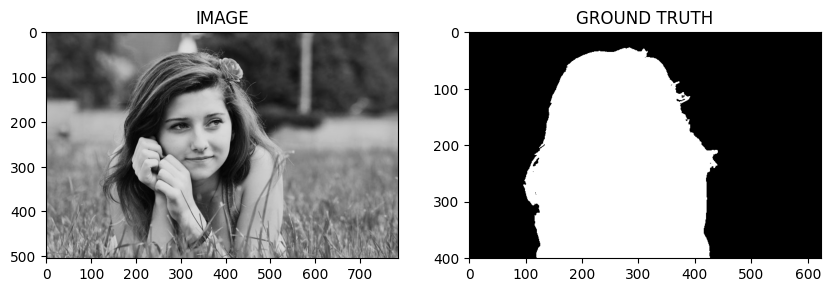

In [179]:
helper.show_image(image, mask)

In [198]:
# AUGMENTATION FUNCTIONS

def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
    ])

In [199]:
# CREATE CUSTOM DATASET

class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image_path = row.images
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_path = row.masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
        mask = np.expand_dims(mask, axis=-1)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]
            
        # (h, w, c) --> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)      
        image = torch.Tensor(image) / 255.0
        
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        mask = torch.Tensor(mask) / 255.0
        mask = torch.round(mask)
        
        return image, mask

In [182]:
# CREATE TRAIN_ VALID SETS

train_df, valid_df = train_test_split(data,
                                      test_size=0.2,
                                      random_state=42)

trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [183]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


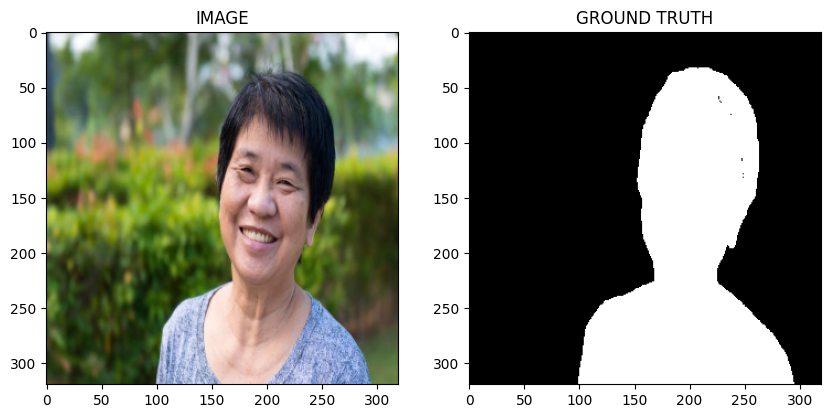

In [184]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask, permutations = True)

In [185]:
# LOAD DATASETS INTO BATCHES

trainloader = DataLoader(trainset, batch_size = BatchSize, shuffle = True)
validloader = DataLoader(validset, batch_size = BatchSize)

In [186]:
print(f"total no. of batches in trainloader: {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [187]:
for image, mask in trainloader:
    break
    
print(f"One batch image shape {image.shape}")
print(f"One batch mask shape {mask.shape}")

One batch image shape torch.Size([16, 3, 320, 320])
One batch mask shape torch.Size([16, 1, 320, 320])


In [188]:
# CREATE SEGMENTATION MODEL

class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks=None):

        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            loss = loss1 + loss2
            return logits, loss

        return logits

In [189]:
model = SegmentationModel()
model.to(DEVICE);

In [190]:
# CREATE TRAIN AND VAL FUNCTIONS

def train_fn(data_loader, model, optimizer):
    
    model.train()
    
    total_loss = 0.0
    
    for images, masks in tqdm(data_loader):
        
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    
    model.eval()
    
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):

            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

        return total_loss / len(data_loader)

In [192]:
# TRAIN MODEL

optimizer = torch.optim.Adam(model.parameters(),
                             lr = LR)

best_validation_loss = np.Inf

for i in range(EPOCHS):
    
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    if valid_loss < best_validation_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print(f"SAVED MODEL AT EPOCH {i+1}")
        best_validation_loss = valid_loss
        
    print(f"Epoch: {i+1}, Train loss: {train_loss}, Valid loss: {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


SAVED MODEL AT EPOCH 1
Epoch: 1, Train loss: 0.8540296991666158, Valid loss: 0.7254264503717422


100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


SAVED MODEL AT EPOCH 2
Epoch: 2, Train loss: 0.415617573261261, Valid loss: 0.43360842019319534


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


SAVED MODEL AT EPOCH 3
Epoch: 3, Train loss: 0.37062632739543916, Valid loss: 0.32864324003458023


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


SAVED MODEL AT EPOCH 4
Epoch: 4, Train loss: 0.27483406762282053, Valid loss: 0.2426474392414093


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


SAVED MODEL AT EPOCH 5
Epoch: 5, Train loss: 0.2557792166868846, Valid loss: 0.23123155534267426


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Epoch: 6, Train loss: 0.1992855449517568, Valid loss: 0.2626343034207821


100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


SAVED MODEL AT EPOCH 7
Epoch: 7, Train loss: 0.20803561061620712, Valid loss: 0.22489982843399048


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch: 8, Train loss: 0.1894396831591924, Valid loss: 0.24695434048771858


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


SAVED MODEL AT EPOCH 9
Epoch: 9, Train loss: 0.1580889398852984, Valid loss: 0.18765612691640854


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Epoch: 10, Train loss: 0.2227034315466881, Valid loss: 0.3183843493461609


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


Epoch: 11, Train loss: 0.17805322458346684, Valid loss: 0.26665807515382767


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


Epoch: 12, Train loss: 0.2497856428225835, Valid loss: 0.28920093178749084


100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


Epoch: 13, Train loss: 0.19091610660155614, Valid loss: 0.2589530348777771


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch: 14, Train loss: 0.1632156809171041, Valid loss: 0.20651118457317352


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Epoch: 15, Train loss: 0.13625162988901138, Valid loss: 0.22842690721154213


100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch: 16, Train loss: 0.14554148217042287, Valid loss: 0.25054046511650085


100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


Epoch: 17, Train loss: 0.12598441690206527, Valid loss: 0.19082637503743172


100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


SAVED MODEL AT EPOCH 18
Epoch: 18, Train loss: 0.10871471911668777, Valid loss: 0.15574824437499046


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


Epoch: 19, Train loss: 0.10883350223302841, Valid loss: 0.18555760756134987


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Epoch: 20, Train loss: 0.09783972452084223, Valid loss: 0.1639263667166233


100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


Epoch: 21, Train loss: 0.10494560400644938, Valid loss: 0.1739147212356329


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Epoch: 22, Train loss: 0.11008197267850241, Valid loss: 0.18136954866349697


100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Epoch: 23, Train loss: 0.10172307044267655, Valid loss: 0.19117284566164017


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Epoch: 24, Train loss: 0.09632156242926916, Valid loss: 0.19843707233667374


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

Epoch: 25, Train loss: 0.09560273985068003, Valid loss: 0.18334593251347542


In [196]:
# USE BEST MODEL FOR PREDICTIONS

idx = 2

model.load_state_dict(torch.load("best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)

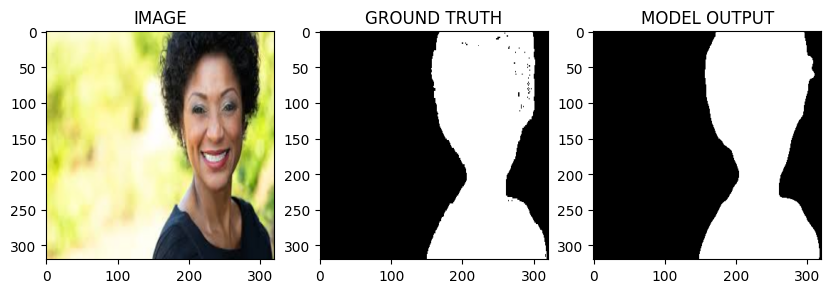

In [197]:
helper.show_image(image, mask, pred_mask, permutations = True)